Raw data sample:

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26052 entries, 0 to 26051
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   index      26052 non-null  int64 
 1   City       26052 non-null  object
 2   Date       26052 non-null  object
 3   Card Type  26052 non-null  object
 4   Exp Type   26052 non-null  object
 5   Gender     26052 non-null  object
 6   Amount     26052 non-null  int64 
dtypes: int64(2), object(5)
memory usage: 1.4+ MB

Unique Cities: 986
Unique Expense Types: ['Bills' 'Food' 'Entertainment' 'Grocery' 'Fuel' 'Travel']

Monthly spend DataFrame for Food in Bengaluru, India:


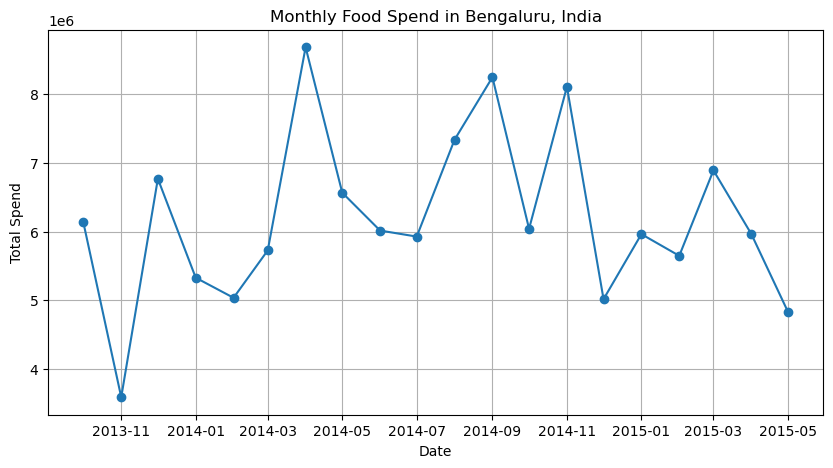

<Figure size 640x480 with 0 Axes>


Training range: 2013-10-01 00:00:00 to 2014-11-01 00:00:00
Testing range: 2014-12-01 00:00:00 to 2015-05-01 00:00:00

Train DF (first 5 rows):
          ds        y
0 2013-10-01  6131646
1 2013-11-01  3586372
2 2013-12-01  6768415
3 2014-01-01  5327136
4 2014-02-01  5034540

Test DF (first 5 rows):
           ds        y
14 2014-12-01  5014455
15 2015-01-01  5961728
16 2015-02-01  5646233
17 2015-03-01  6890633
18 2015-04-01  5964474


00:33:14 - cmdstanpy - INFO - Chain [1] start processing
00:33:17 - cmdstanpy - INFO - Chain [1] done processing



Forecasted values (last 6 months):


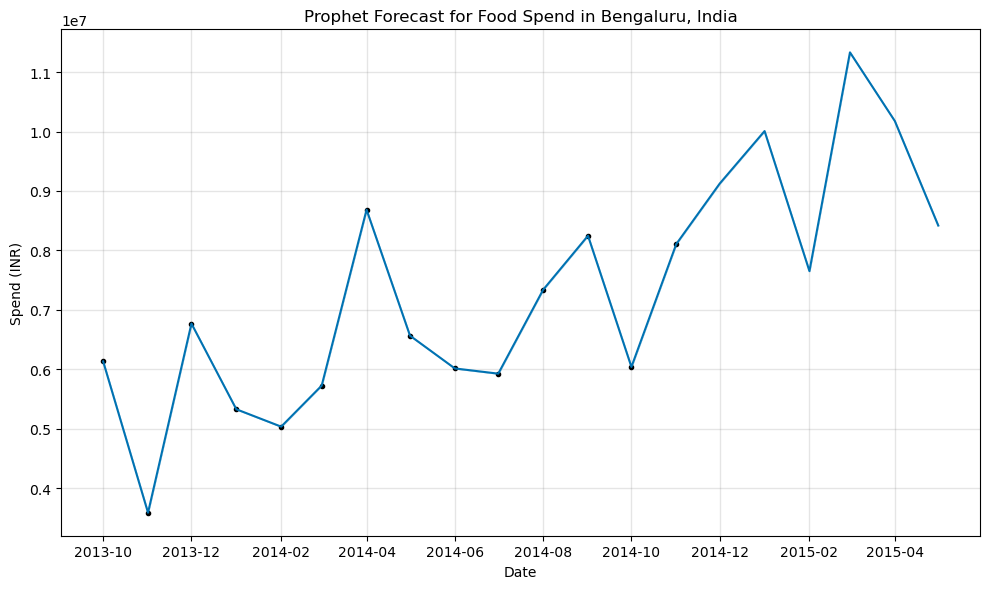

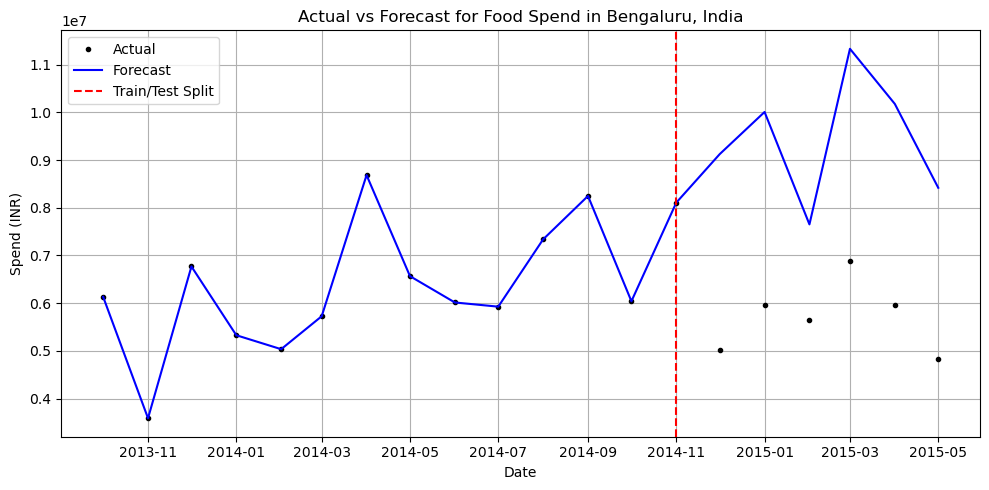


Mean Absolute Error (last 6 months): 3733814.98

Actual vs Forecast (Test Period):
          ds        y         yhat
0 2014-12-01  5014455   9124268.15
1 2015-01-01  5961728  10008112.73
2 2015-02-01  5646233   7651291.65
3 2015-03-01  6890633  11332685.14
4 2015-04-01  5964474  10177087.20
5 2015-05-01  4831701   8418669.02


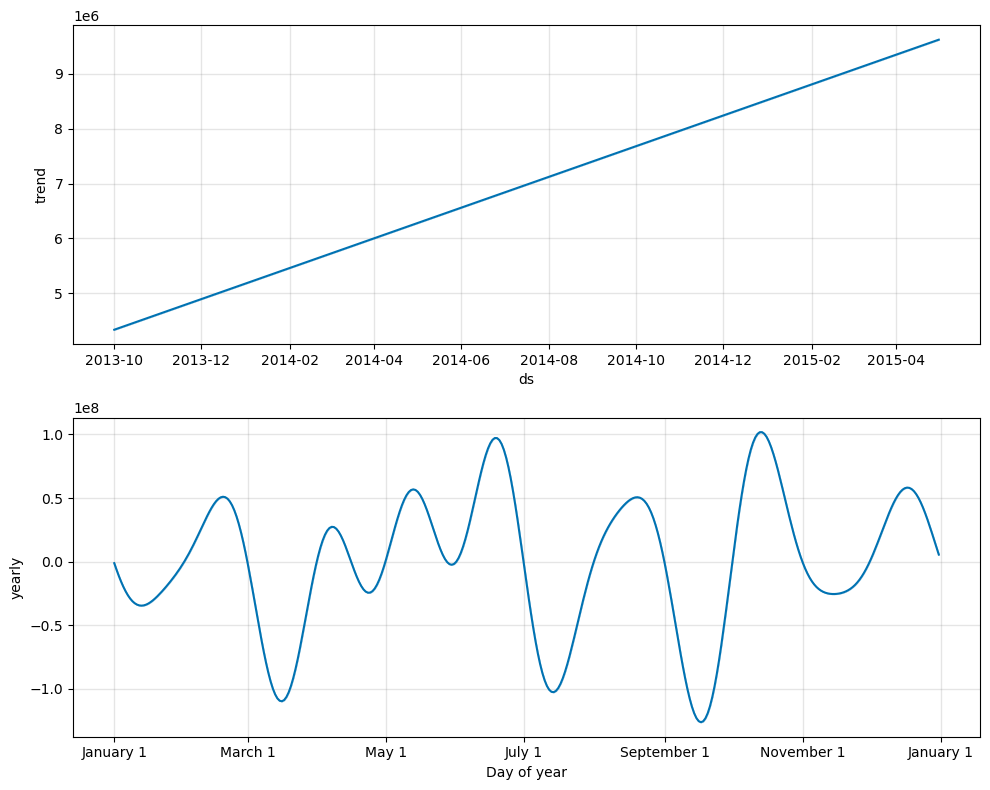

Test‐period dates (test_df['ds']):
[Timestamp('2014-12-01 00:00:00'), Timestamp('2015-01-01 00:00:00'), Timestamp('2015-02-01 00:00:00'), Timestamp('2015-03-01 00:00:00'), Timestamp('2015-04-01 00:00:00'), Timestamp('2015-05-01 00:00:00')]

Forecasted dates (forecast['ds'] > train cutoff):
[Timestamp('2014-12-01 00:00:00'), Timestamp('2015-01-01 00:00:00'), Timestamp('2015-02-01 00:00:00'), Timestamp('2015-03-01 00:00:00'), Timestamp('2015-04-01 00:00:00'), Timestamp('2015-05-01 00:00:00')]


In [1]:
# 3_prophet_forecast.ipynb
#**Credit Card Spend Forecasting (Prophet)**  
#This notebook demonstrates how to:
#1. Load and aggregate monthly spend
#2. Train a Prophet model on 14 months of data
#3. Forecast 6 months ahead with uncertainty
#4. Compute Mean Absolute Error on the holdout set
#5. Plot actual vs. forecast and Prophet components



#───────────────────────────────────────────────────────────────────────────────
# 1. Install and Import Required Libraries
# ─────────────────────────────────────────────────────────────────────────────── 

 
!pip install prophet  

import pandas as pd  
import numpy as np  
import matplotlib.pyplot as plt  

# For forecasting  
from prophet import Prophet  

# For evaluation  
from sklearn.metrics import mean_absolute_error  

# Ensure plots display inline in Jupyter  
%matplotlib inline  


# ───────────────────────────────────────────────────────────────────────────────
# 2. Load the Dataset
# ───────────────────────────────────────────────────────────────────────────────

# The dataset is available at /kaggle/input/analyzing-credit-card-spending-habits-in-india
data_path = '../data/Credit card transactions - India - Simple.csv'
df = pd.read_csv(data_path)
# Peek at the raw data
print("Raw data sample:")
df.head()

# ───────────────────────────────────────────────────────────────────────────────
# 3. Inspect Dataset Structure
# ───────────────────────────────────────────────────────────────────────────────

print("\nDataset Info:")
df.info()

print("\nUnique Cities:", df['City'].nunique())
print("Unique Expense Types:", df['Exp Type'].unique())


counts = df.groupby(['City', 'Exp Type']).size().reset_index(name='Count')
counts.sort_values('Count', ascending=False).head(10)


# ───────────────────────────────────────────────────────────────────────────────
# 4. Preprocess Date and Filter for One City & Category
#We will convert the `Date` column to datetime, then group by “YearMonth” for monthly totals.  
#Next, we filter to a single city+category for forecasting (e.g. “Bengaluru, India” + “Food”).  
# ───────────────────────────────────────────────────────────────────────────────

# Convert 'Date' to datetime
df['Date'] = pd.to_datetime(df['Date'], format='%d-%b-%y')

# Create a 'YearMonth' column for monthly aggregation
df['YearMonth'] = df['Date'].dt.to_period('M').dt.to_timestamp()

# Choose one city and one category to forecast (e.g., "Grocery" in "Mumbai")
city = 'Bengaluru, India'
category = 'Food'

mask = (df['City'] == city) & (df['Exp Type'] == category)
df_city_cat = df.loc[mask, ['YearMonth', 'Amount']].copy()

# Aggregate spend per month
monthly_spend = (
    df_city_cat
    .groupby('YearMonth')['Amount']
    .sum()
    .reset_index()
    .rename(columns={'YearMonth': 'ds', 'Amount': 'y'})
)

print(f"\nMonthly spend DataFrame for {category} in {city}:")
monthly_spend.head(10)

# ───────────────────────────────────────────────────────────────────────────────
# 5. Visualize the Historical Monthly Spend
# ───────────────────────────────────────────────────────────────────────────────
import os  
os.makedirs("../notebooks/assets", exist_ok=True)  

plt.figure(figsize=(10, 5))
plt.plot(monthly_spend['ds'], monthly_spend['y'], marker='o')
plt.title(f'Monthly {category} Spend in {city}')
plt.xlabel('Date')
plt.ylabel('Total Spend')
plt.grid(True)
plt.show()

# Save the figure as a PNG
plt.tight_layout()  
plt.savefig("../notebooks/assets/monthly_spend_plot.png")  
plt.show() 
# ───────────────────────────────────────────────────────────────────────────────
# 6. Train-Test Split for Time Series
#We will hold out the final 6 months for testing and use the preceding months for training.  
# ───────────────────────────────────────────────────────────────────────────────

# Reserve the final 6 months for testing
train_cutoff = monthly_spend['ds'].max() - pd.DateOffset(months=6)
train_df = monthly_spend[monthly_spend['ds'] <= train_cutoff]
test_df  = monthly_spend[monthly_spend['ds'] > train_cutoff]

print("\nTraining range:", train_df['ds'].min(), "to", train_df['ds'].max())
print("Testing range:", test_df['ds'].min(), "to", test_df['ds'].max())

# Peek at train and test DataFrames  
print("\nTrain DF (first 5 rows):")  
print(train_df.head())  
print("\nTest DF (first 5 rows):")  
print(test_df.head()) 
# ───────────────────────────────────────────────────────────────────────────────
# 7. Fit a Prophet Model on Training Data
#We instantiate a Prophet model (with yearly seasonality turned on) and fit it to the training data.  
# ───────────────────────────────────────────────────────────────────────────────

m = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
m.fit(train_df)

# ───────────────────────────────────────────────────────────────────────────────
# 8. Create Future DataFrame and Forecast
# We ask Prophet to forecast for 6 months beyond the training cutoff.  
# ───────────────────────────────────────────────────────────────────────────────

future = m.make_future_dataframe(periods=6, freq='MS')
forecast = m.predict(future)

# Show only the forecasted portion (beyond the training data)
future_only = forecast[forecast['ds'] > train_df['ds'].max()]  
print("\nForecasted values (last 6 months):")  
future_only[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].round(2) 
# ───────────────────────────────────────────────────────────────────────────────
# 9. Visualize Forecast vs Actual
# ───────────────────────────────────────────────────────────────────────────────

# Full forecast plot
fig1 = m.plot(forecast, figsize=(10, 6))
plt.title(f'Prophet Forecast for {category} Spend in {city}')
plt.xlabel('Date')
plt.ylabel('Spend (INR)') 
# Save the forecast plot as PNG
fig1.tight_layout()  
fig1.savefig("../notebooks/assets/prophet_forecast.png")  
plt.show()

# Zoomed-in comparison of actual vs forecast
plt.figure(figsize=(10, 5))
plt.plot(monthly_spend['ds'], monthly_spend['y'], 'k.', label='Actual')
plt.plot(forecast['ds'], forecast['yhat'], 'b-', label='Forecast')
plt.axvline(train_df['ds'].max(), color='red', linestyle='--', label='Train/Test Split')
plt.title(f'Actual vs Forecast for {category} Spend in {city}')
plt.xlabel('Date')
plt.ylabel('Spend (INR)') 
plt.legend()  
plt.grid(True)  
plt.tight_layout()  
plt.show()  

# ───────────────────────────────────────────────────────────────────────────────
# 10. Evaluate Forecast Performance on Test Set
# ───────────────────────────────────────────────────────────────────────────────

eval_df = test_df.merge(forecast[['ds','yhat']], on='ds', how='left')
eval_df = eval_df.dropna(subset=['y','yhat'])
mae = mean_absolute_error(eval_df['y'], eval_df['yhat'])
print(f"\nMean Absolute Error (last 6 months): {mae:.2f}\n")
print("Actual vs Forecast (Test Period):")
print(eval_df[['ds','y','yhat']].round(2))


# ───────────────────────────────────────────────────────────────────────────────
# 11.Plot Prophet Components: Trend and Seasonality
# ───────────────────────────────────────────────────────────────────────────────

fig2 = m.plot_components(forecast, figsize=(10, 8))
fig2.savefig("../notebooks/assets/prophet_components.png")  
plt.show()

# === End of Notebook ===

# Display the exact test‐period dates and forecasted dates for reference:
print("Test‐period dates (test_df['ds']):")  
print(test_df['ds'].tolist())  

print("\nForecasted dates (forecast['ds'] > train cutoff):")  
print(future_only['ds'].tolist())  
